# NLP Model Evaluation 

In this notebook, we will evaluate three models for the NLP component of Gredient. We will use self-collected data that contains images and annotations of product safety, given a set of allergens. Since Textract has been proven to do well on time and accuracy, we will move forward with evaluating NLP models on detections from Textract. 

The three models are (1) a perfect matching mechanism, (2) cosine similarity with CountVectorizer character embeddings, and (3) cosine similarity with Chars2Vec character embeddings. For the latter two, we tune the threshold of the cosine similarity scores to observe which setting would result in an acceptable balance between the true positive rate and the false positive rate. When the threshold is higher, the model makes fewer matches between allergens and ingredients, and thus has an increased false positive rate. Basic match represents the accuracy metrics at the highest threshold, where the cosine similarity score equals 1. 

A true positive takes place when the model correctly signals a product to be safe, since there are no ingredient and allergen matches. On the other hand, a false positive is when a model signals a product to be safe when it is actually unsafe.   



### Import some libraries...

In [1]:
import boto3 
import botocore 
from sagemaker import get_execution_role 

import PIL
from PIL import Image
import s3fs
from io import BytesIO

import pandas as pd
import numpy as np
import re 
import string
import time

import chars2vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

### Connect to S3 and read data...

In [2]:
# read true safety annotations
role = get_execution_role() 
data_location = 's3://{}/{}'.format('sagemaker-060720', 'true_safety.csv') 
true_safety = pd.read_csv(data_location)

In [3]:
# read images and file names
file_names = []
imgs = []

fs = s3fs.S3FileSystem()
for img_path in fs.ls('s3://sagemaker-060720/Images/'):
    file_name = img_path[24:]
    file_names.append(file_name)
    with fs.open(f's3://'+img_path) as f:
        pil_img = Image.open(f)
        buff = BytesIO()
        pil_img.save(buff, format="JPEG")
        img_bytes = buff.getvalue()
        imgs.append(img_bytes)
    

### Preprocess for NLP...

In [4]:
# add allergens column 
true_safety['allergens'] = "na"

isaac = 'milk, cheese, soy, cream, eggs'
jj = 'peanuts, whey, tree nuts'
chelsea = 'Shrimp, Prawns, Lobster, Crab'
emma = 'wheat, barely, rye triticale'
silvia = 'garlic, avocado, celery'

true_safety.loc[0:10, 'allergens'] = emma
true_safety.loc[10:21, 'allergens'] = silvia
true_safety.loc[21:45, 'allergens'] = isaac
true_safety.loc[45:55, 'allergens'] = jj
true_safety.loc[55:65, 'allergens'] = chelsea

In [5]:
print(true_safety.shape)
true_safety.head()

(65, 4)


,Item,Name,Label,allergens
0,0,emma-1.jpg,0,"wheat, barely, rye triticale"
1,1,emma-2.jpg,0,"wheat, barely, rye triticale"
2,2,emma-3.jpg,0,"wheat, barely, rye triticale"
3,3,emma-4.jpg,0,"wheat, barely, rye triticale"
4,4,emma-5.jpg,1,"wheat, barely, rye triticale"


In [6]:
# allergens and labels corresponding to images
allergens = []
labels = []

for file_name in file_names:
    
    true_vals = true_safety.loc[true_safety.Name == file_name,]
    
    allgs = true_vals.allergens.values[0]
    allergens.append(allgs)
    
    label = true_vals.Label.values[0]
    labels.append(label)

In [7]:
# Textract detections 
detected = []

for img in imgs:

    tex_client = boto3.client('textract')
    tex_dect = tex_client.detect_document_text(Document={"Bytes":img})

    tex_text = [text['Text'] if text['BlockType']=='WORD' else "" for text in tex_dect['Blocks']]
    detected.append(tex_text)    

### Helpful Functions

In [8]:
# clean words 
def clean_word (word):
    
    c_word = word.lower().strip() # lowercase and remove white space
    c_word = re.sub('[^a-zA-Z]+', '', c_word) # remove anything that's not a letter
    if len(c_word) < 2: # remove words that are less than 2 characters
        c_word = "" 
    
    return c_word

# clean string of words
def clean_text (text, split=True):
    
    if split == False: # for ocr output
        c_text = [clean_word(w) for w in text] # already split and clean words
        
    else: 
        c_text = re.sub('[0-9]', ' ', text) # replace numbers with space 
        c_text = re.sub('['+string.punctuation+']', ' ', c_text) # replace punctuation with space
        c_text = [clean_word(w) for w in c_text.split()] # split on spaces and clean words
      
    c_text = sorted(list(filter(None, set(c_text)))) # remove empty words and get unique values and sort
    
    return c_text

In [9]:
# positive: safe ; negative: unsafe
# true positives: #(classified safe products that are actually safe) 
# false positives: #(classified safe products that are actually unsafe) <- NOT GOOD 
# true negatives: #(classified unsafe products that are actually unsafe)
# false negatives: #(classified unsafe products that are actually safe)

def pred_stats(pred_safety, true_safety):
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(pred_safety)):
        if (pred_safety[i]=="safe") & (true_safety[i]==1):
            tp += 1
        if (pred_safety[i]=="safe") & (true_safety[i]==0):
            fp += 1
        if (pred_safety[i]=="unsafe") & (true_safety[i]==0):
            tn += 1
        if (pred_safety[i]=="unsafe") & (true_safety[i]==1):
            fn += 1
    
    if tp == 0:
        p = 0
        r = 0
        f1score = 0
    else: 
        p = tp/(tp+fp)
        r = tp/(tp+fn)
        f1score = (2*p*r)/(p+r)
        
    return [tp,fp,tn,fn,p,r,f1score]

In [10]:
# detect the safety of ingredients for a given similarity score 
def dect_safety(safety_func, sim):  
    
    start_time = time.time()
    
    safety = [safety_func(allgs, ings, sim) for allgs,ings in zip(clean_allergens, clean_detected)]
    
    t_time = (time.time() - start_time)/65
    print("--- %s seconds ---" % t_time)
    
    return [safety, t_time]

### Cleaned list of detections and allergens

In [11]:
clean_detected = [clean_text(tex_text, split=False) for tex_text in detected]
clean_allergens = [clean_text(allgs) for allgs in allergens]

## Perfect Match 

In [12]:
# apply perfect matching
def safety_perfect (allergens, ingredients): 
    if len(ingredients) == 0 or ingredients == ['']:
        return "Nothing detected. Please retake photo." 
    else: 
        ocr_safety = [a in ingredients for a in allergens] # creates boolean array of presence of allergen in ingredients
        if sum(ocr_safety) > 0:
            return "unsafe"
        else: return "safe"

In [13]:
start_time = time.time()

perfect_safety = [safety_perfect(allgs, ings) for allgs,ings in zip(clean_allergens, clean_detected)]

print("--- %s seconds ---" % ((time.time() - start_time)/(65))) # 7.2e-06 seconds

--- 8.16491933969351e-06 seconds ---


In [14]:
perfect_scores = pred_stats(perfect_safety, labels)
perfect_scores

[37, 4, 22, 1, 0.9024390243902439, 0.9736842105263158, 0.9367088607594938]

## CountVectorizer

In [15]:
def safety_count (allergens, ingredients, sim):
    if len(ingredients) == 0 or ingredients == ['']:
        return "Nothing detected. Please retake photo." 
    else:
        vectorizer = CountVectorizer(analyzer='char')
        words = allergens + ingredients # create list of allergens and ingredients 
        word_embeddings = vectorizer.fit_transform(words) # embeddings for allergens and ingredients 
        cos_sims = cosine_similarity(word_embeddings[:len(allergens)], word_embeddings[len(allergens):]) # cos sim of allergens and ingredients 
        counts = [sum(all_sims) for all_sims in cos_sims > sim] # counts of ingredients with a 'sim' greater cos sim to each allergen 
        if sum(counts) > 0:
            return "unsafe" 
        else: return "safe" 

In [16]:
count_sims = [0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1]
count_safety = [dect_safety(safety_count, sim) for sim in count_sims]

--- 0.0026391066037691558 seconds ---
--- 0.002550697326660156 seconds ---
--- 0.002513287617610051 seconds ---
--- 0.00252072994525616 seconds ---
--- 0.0025115306560809796 seconds ---
--- 0.0025214378650371843 seconds ---
--- 0.0025505982912503757 seconds ---
--- 0.002487043234018179 seconds ---


In [17]:
count_safe = [count_s[0] for count_s in count_safety] # detected safety for each cosine threshold
print(sum([count_s[1] for count_s in count_safety])/len(count_sims)) # average time: 0.0025

0.00253680394246028


In [18]:
count_scores = [pred_stats(count_safe[i], labels) for i in range(len(count_sims))] # scores for each cosine
count_scores

[[6, 0, 26, 32, 1.0, 0.15789473684210525, 0.2727272727272727],
 [8, 1, 25, 30, 0.8888888888888888, 0.21052631578947367, 0.3404255319148936],
 [12, 1, 25, 26, 0.9230769230769231, 0.3157894736842105, 0.47058823529411764],
 [23, 1, 25, 15, 0.9583333333333334, 0.6052631578947368, 0.7419354838709677],
 [28, 2, 24, 10, 0.9333333333333333, 0.7368421052631579, 0.8235294117647058],
 [33, 2, 24, 5, 0.9428571428571428, 0.868421052631579, 0.904109589041096],
 [36, 3, 23, 2, 0.9230769230769231, 0.9473684210526315, 0.935064935064935],
 [37, 10, 16, 1, 0.7872340425531915, 0.9736842105263158, 0.8705882352941177]]

## Chars2Vec

In [19]:
def safety_chars (allergens, ingredients, sim):
    if len(ingredients) == 0 or ingredients == ['']:
        return "Nothing detected. Please retake photo."
    else:
        c2v_model = chars2vec.load_model('eng_50')
        words = allergens + ingredients # create list of allergens and ingredients 
        word_embeddings = c2v_model.vectorize_words(words) # embeddings for allergens and ingredients 
        cos_sims = cosine_similarity(word_embeddings[:len(allergens)], word_embeddings[len(allergens):]) # cos sim of allergens and ingredients 
        counts = [sum(all_sims) for all_sims in cos_sims > sim] # counts of ingredients with a 'sim' greater cos sim to each allergen 
        if sum(counts) > 0:
            return "unsafe"
        else: return "safe"

In [20]:
chars_sims = [0.75, 0.80, 0.85, 0.90, 0.95, 1]
chars_safety = [dect_safety(safety_chars, sim) for sim in chars_sims]

--- 2.2281713485717773 seconds ---
--- 2.2876782087179333 seconds ---
--- 2.361599907508263 seconds ---
--- 2.4540147194495567 seconds ---
--- 2.4723326426285963 seconds ---
--- 2.460872631806594 seconds ---


In [21]:
chars_safe = [chars_s[0] for chars_s in chars_safety] # detected safety for all ingredients for every cosine threshold
print(sum([chars_s[1] for chars_s in chars_safety])/len(chars_sims)) # average time: 2.40915

2.3774449097804538


In [22]:
chars_scores = [pred_stats(chars_safe[i], labels) for i in range(len(chars_sims))] # scores for each cosine
chars_scores

[[17, 0, 26, 21, 1.0, 0.4473684210526316, 0.6181818181818182],
 [24, 1, 25, 14, 0.96, 0.631578947368421, 0.7619047619047619],
 [30, 2, 24, 8, 0.9375, 0.7894736842105263, 0.8571428571428572],
 [36, 3, 23, 2, 0.9230769230769231, 0.9473684210526315, 0.935064935064935],
 [37, 4, 22, 1, 0.9024390243902439, 0.9736842105263158, 0.9367088607594938],
 [38, 20, 6, 0, 0.6551724137931034, 1.0, 0.7916666666666666]]

## ROC and AUC

For different thresholds of the cosine similarity score, we can draw an ROC curve to determine the best threshold for the tradeoff we are willing to accept. We can also compare CountVectorizer and Chars2Vec based on their AUC.

### Helpful Functions

In [23]:
# sensitivity = recall =  tp/(tp+fn) : true safe detections out of all safe
def tpr(tex_scores): 
    return [scores[5] for scores in tex_scores]
  
# 1-specificity = false positive rate = fp/(fp+tn) : false safe detections out of all unsafe
def fpr(tex_scores):
    return [scores[1]/(scores[1]+scores[2]) for scores in tex_scores if (scores[1]+scores[2])!=0]
    
# (0:tp, 1:fp, 2:tn, 3:fn, 4:p, 5:r, 6:f1score) 

In [24]:
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "sans-serif"

def plotROC (scores1, scores2, scores3):
    
    x1 = fpr(scores1)
    y1 = tpr(scores1)

    x2 = fpr(scores2)
    y2 = tpr(scores2)
    
    x3 = scores3[1]/(scores3[1]+scores3[2])
    y3 = scores3[5]

    fig, ax = plt.subplots(figsize=(15,10))
    
    plt.plot([0, 0, 1], [0, 1, 1], '--', alpha=0.5, c="#ff6666") #, label='Perfect Classifier'
    plt.plot([0,1], [0,1], ':', alpha=0.5, c="#0099ff") #, label='Random Classifier'

    plt.ylabel("True Positive Rate (Sensitivity)", color="#447b72", weight="bold", fontsize=20)
    plt.yticks(fontsize=15, color="#234943")
    plt.xlabel("False Positive Rate (1-Specificity)", color="#447b72", weight="bold", fontsize=20)
    plt.xticks(fontsize=15, color="#234943")
    #plt.title("All Images")

    plt.plot(x3, y3, 'D', label='Basic Match', alpha=0.75, markersize=12, c="#6331d8")
    plt.plot(x1, y1, label='CountVectorizer', c="#33cccc")
    plt.plot(x2, y2, label='Chars2Vec', c="#ffcc66")
    plt.plot(x3, y3, 'D', alpha=0.75, markersize=12, c="#6331d8")

    legend = ax.legend(loc='center right', edgecolor='#447b72', shadow=True, prop={'weight':'bold', 'size':15})
    frame = legend.get_frame()
    frame.set_facecolor("white")
    
    for text in legend.get_texts():
        text.set_color("#447b72")
        
    vertsp = [(0, 0), *zip(np.linspace(0, 1), [1]*len(np.linspace(0, 1))), (1, 0)]
    polyp = Polygon(vertsp, facecolor='0.9', edgecolor='0.5', color="#ff9933", alpha=0.1)
    ax.add_patch(polyp)

    verts2 = [(x2[0], 0), *zip(x2, y2), (x2[-1], 0)]
    poly2 = Polygon(verts2, facecolor='0.9', edgecolor='0.5', color="#ffff99", alpha=0.3)
    ax.add_patch(poly2)
    
    verts1 = [(x1[0], 0), *zip(x1, y1), (x1[-1], 0)]
    poly1 = Polygon(verts1, facecolor='0.9', edgecolor='0.5', color="#66ffcc", alpha=0.3)
    ax.add_patch(poly1)
    
    fig.set_facecolor('white')
    ax.set_facecolor("white")

    for i, txt in enumerate(count_sims):
        ax.annotate(txt, (x1[i], y1[i]+0.02), fontsize=10)
        
    for i, txt in enumerate(chars_sims):
        ax.annotate(txt, (x2[i], y2[i]+0.02), fontsize=10)

    ax.annotate("Perfect Classifier", (0.715, 0.96), fontsize=17, c="#ff6666", weight='bold', alpha=0.8)
    ax.annotate("Random Classifier", (0.45, 0.40), fontsize=17, rotation=31.5, c="#0099ff", weight='bold', alpha=0.8)
    
    plt.savefig("lol.jpg")

    return plt

<ipython-input-24-10323f17c43e>:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  polyp = Polygon(vertsp, facecolor='0.9', edgecolor='0.5', color="#ff9933", alpha=0.1)
<ipython-input-24-10323f17c43e>:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly2 = Polygon(verts2, facecolor='0.9', edgecolor='0.5', color="#ffff99", alpha=0.3)
<ipython-input-24-10323f17c43e>:47: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly1 = Polygon(verts1, facecolor='0.9', edgecolor='0.5', color="#66ffcc", alpha=0.3)


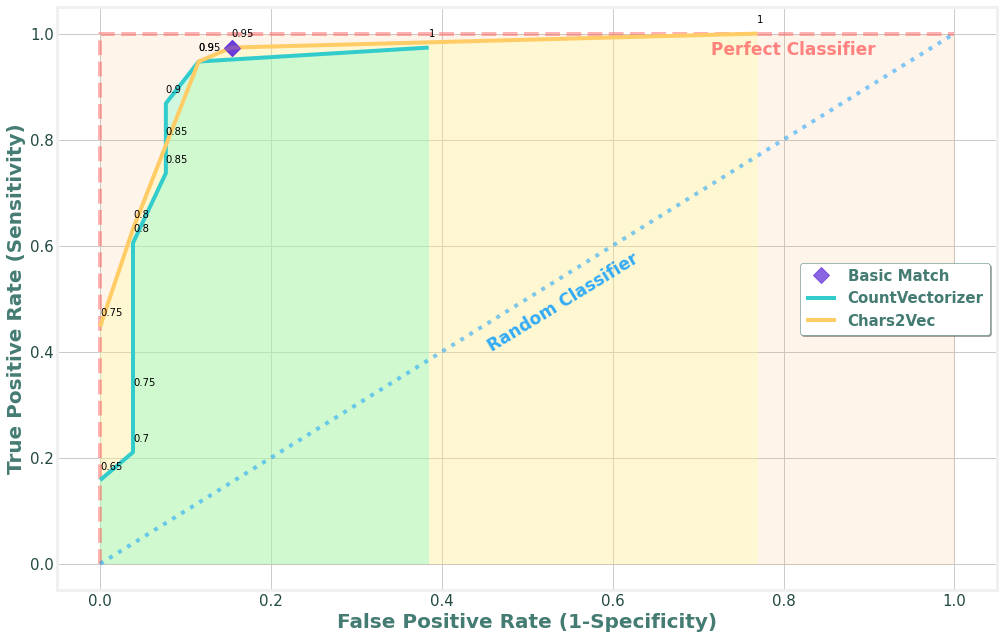

In [25]:
plt = plotROC(count_scores, chars_scores, perfect_scores) # top ingredients 

plt.show()